In [1]:
import sys
sys.path.append("../")

import utils
from crbm import CRBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import subprocess as sp
import matplotlib.image as mpimg

In [2]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/pig_trained_crbms/ge2/"
rounds = ["b3", "n1", "np1", "np2", "np3"]
c1_rounds = [x + "_c1" for x in rounds]
c2_rounds = [x + "_c2" for x in rounds]

#### Generate Weights

In [3]:
# generate weights in respective
for rid, round in enumerate(c2_rounds):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = CRBM.load_from_checkpoint(checkp)
    utils.all_weights(tmp, name=version_dir +round)

../utils.py:809: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (95040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [6]:
# Stores all data in a dictionary ("data")
data_c2 = am.fetch_data(c2_rounds, dir="../../pig_tissue/gaps_end_2_clusters/", counts=True)

Process Time 0.7256288528442383
Process Time 0.6438915729522705
Process Time 0.809349775314331
Process Time 0.2497882843017578
Process Time 0.49628710746765137


In [5]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in c2_rounds:
    paths_u.append(am.seq_logo(data_c2[data_c2["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(data_c2[data_c2["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/"))

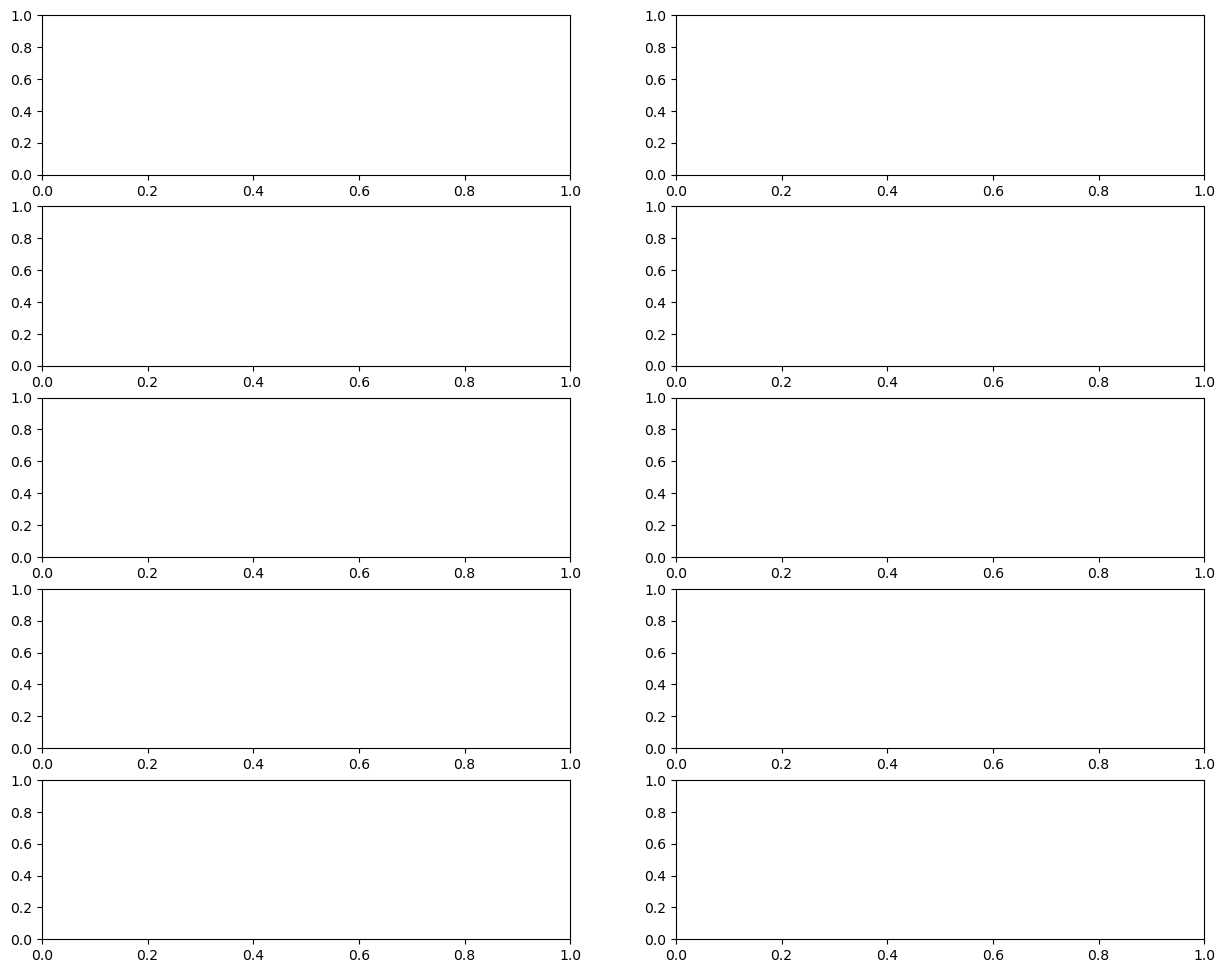

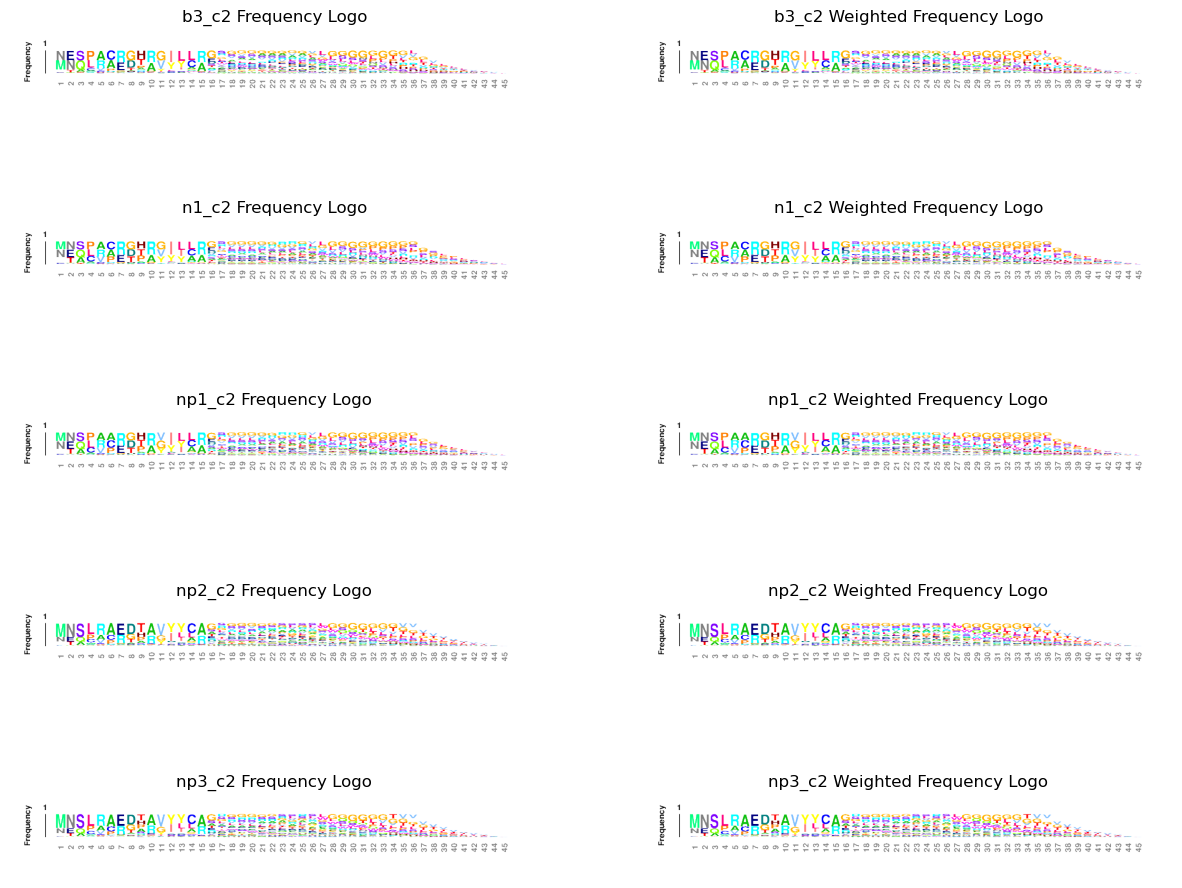

In [7]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(c2_rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

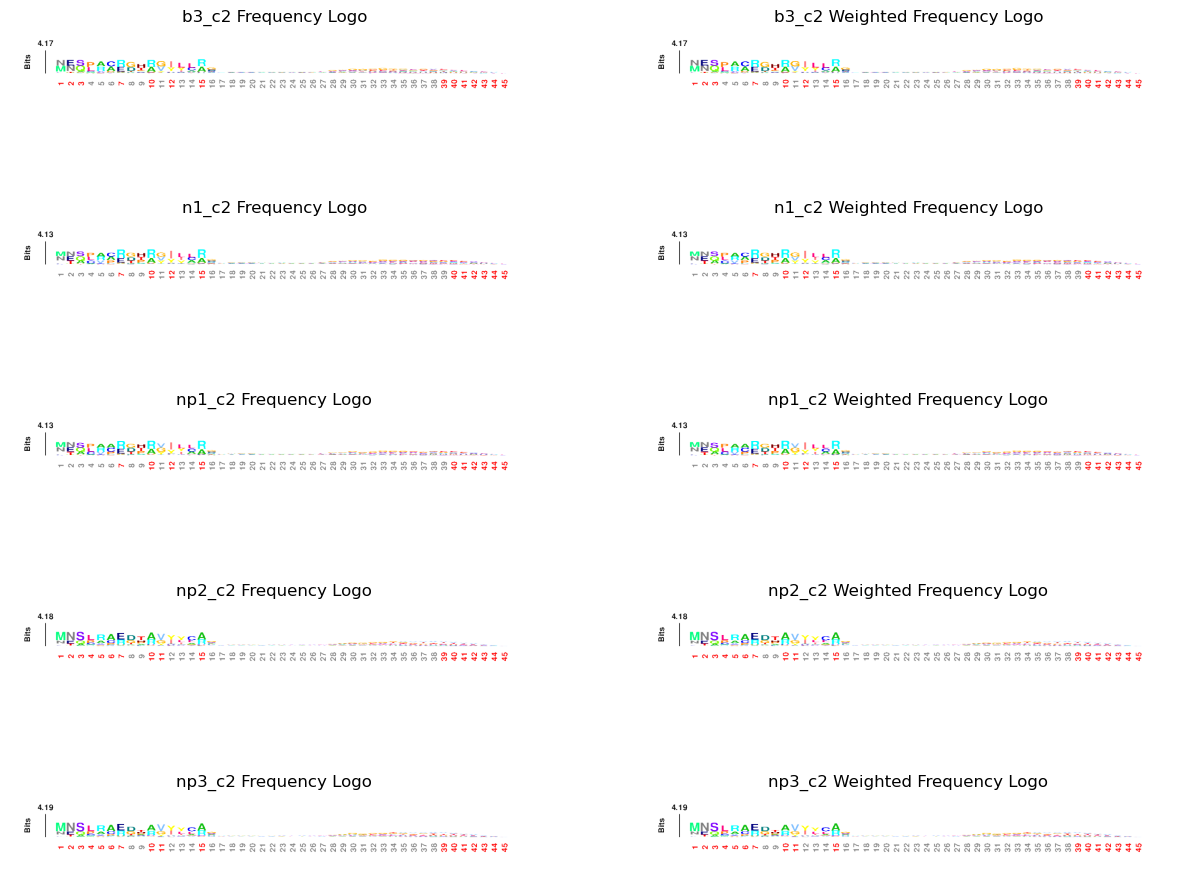

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(c2_rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [9]:
am.count_dist(data_c2, "Unique Sequence Count Distribution C2")

ValueError: cannot set using a list-like indexer with a different length than the value

In [7]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("np3_c2", rbmdir=mdir)
np3_crbm = CRBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(c2_rounds, np3_crbm, data_c2, "np3_c2_crbm_v0")

In [8]:
np3_c2_likelihoods = am.get_likelihoods("./generated/np3_c2_crbm_v0.json")

/home/jonah/PycharmProjects/phage_display_ML/rbm_torch/analysis/analysis_methods.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(plot_num, 1, sharex=True, sharey=False)


<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 2200x2700 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 2200x2700 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 2200x2700 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 2200x2700 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 2200x2700 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

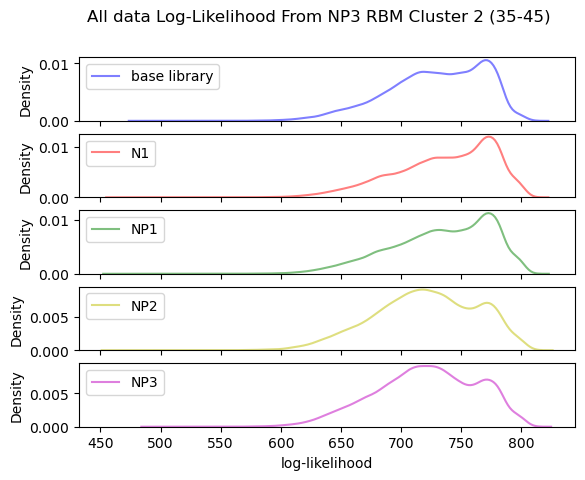

In [9]:
# Plot Likelihoods of Each batch of Data
np3_title = "All data Log-Likelihood From NP3 RBM Cluster 2 (35-45)"

am.plot_likelihoods(np3_c2_likelihoods["likelihoods"], c2_rounds, ["base library", "N1", "NP1", "NP2", "NP3"], title=np3_title, xlim=None, cdf=False)

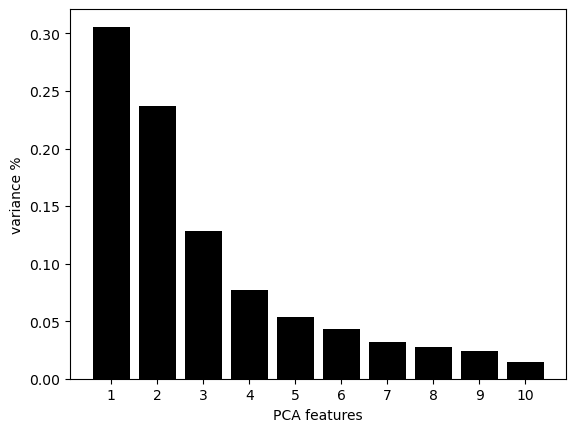

In [11]:
import torch


def dataframe_to_input(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten


# Produces flat vector of Inputs of each hidden unit (reduced over the convolution dimension (k) by sum or mean)
def flatten_and_reduce_input(Ih, reduction="sum"):
    # Iuk (Batch, hidden number (u), conv number (k))
    if reduction == "sum":
        return torch.cat([Iuk.sum(2) for Iuk in Ih], 1)
    elif reduction == "mean":
        return torch.cat([Iuk.mean(2) for Iuk in Ih], 1)
    else:
        print(f"Reduction {reduction} not supported", file=sys.stderr)
        exit(-1)


def prepare_input_vector(crbm, dataframe):
    if type(dataframe) == pd.DataFrame:
        base_to_id = am.int_to_letter_dicts[crbm.molecule]
        data_tensor, weights = dataframe_to_input(dataframe, base_to_id, crbm.v_num, crbm.q, weights=True)
    elif type(dataframe) == torch.Tensor:
        data_tensor = dataframe
    input_hiddens = crbm.compute_output_v(data_tensor)  # List of Iuk matrices
    return flatten_and_reduce_input(input_hiddens).detach().numpy()


from sklearn.preprocessing import StandardScaler

input = prepare_input_vector(np3_crbm, data_c2[data_c2["round"] == "np3_c2"])
scaler = StandardScaler()
input_processed = scaler.fit_transform(input)

import clustering_methods as cm
cm.pca_component_check(input_processed, components=10)

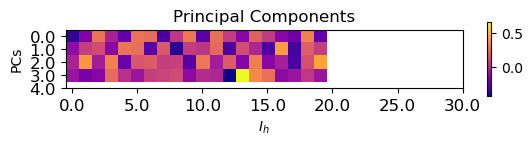

In [12]:
# We will do the first 4 components only, Drop in variance at feature 5
from sklearn.decomposition import PCA
X = input_processed
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X)
PCA_components_pd = pd.DataFrame(principal_components)
components = pca.components_
cm.view_components(components)

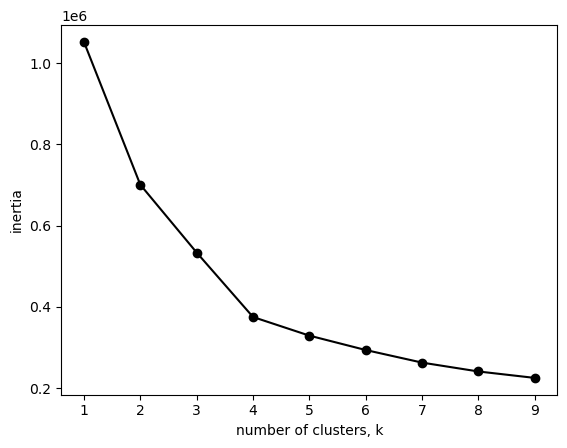

In [13]:
# KMeans on Transformed Sequences
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_pd.iloc[:,:4])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [14]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=7, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([data_c2[data_c2["round"] == "np3_c2"].reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'1', 1:'2', 2:"3", 3:'4', 4:'5', 5:"6", 6:"7", 7:"8"})

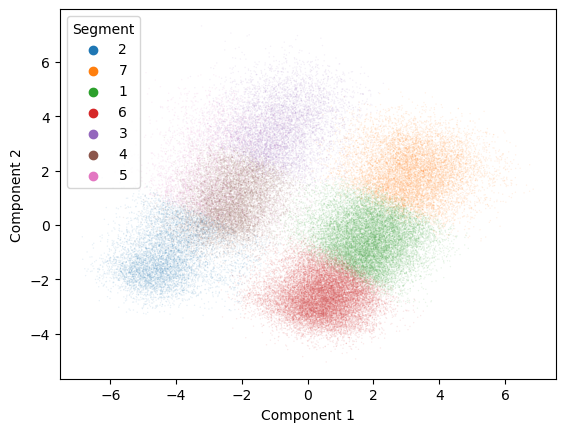

In [15]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

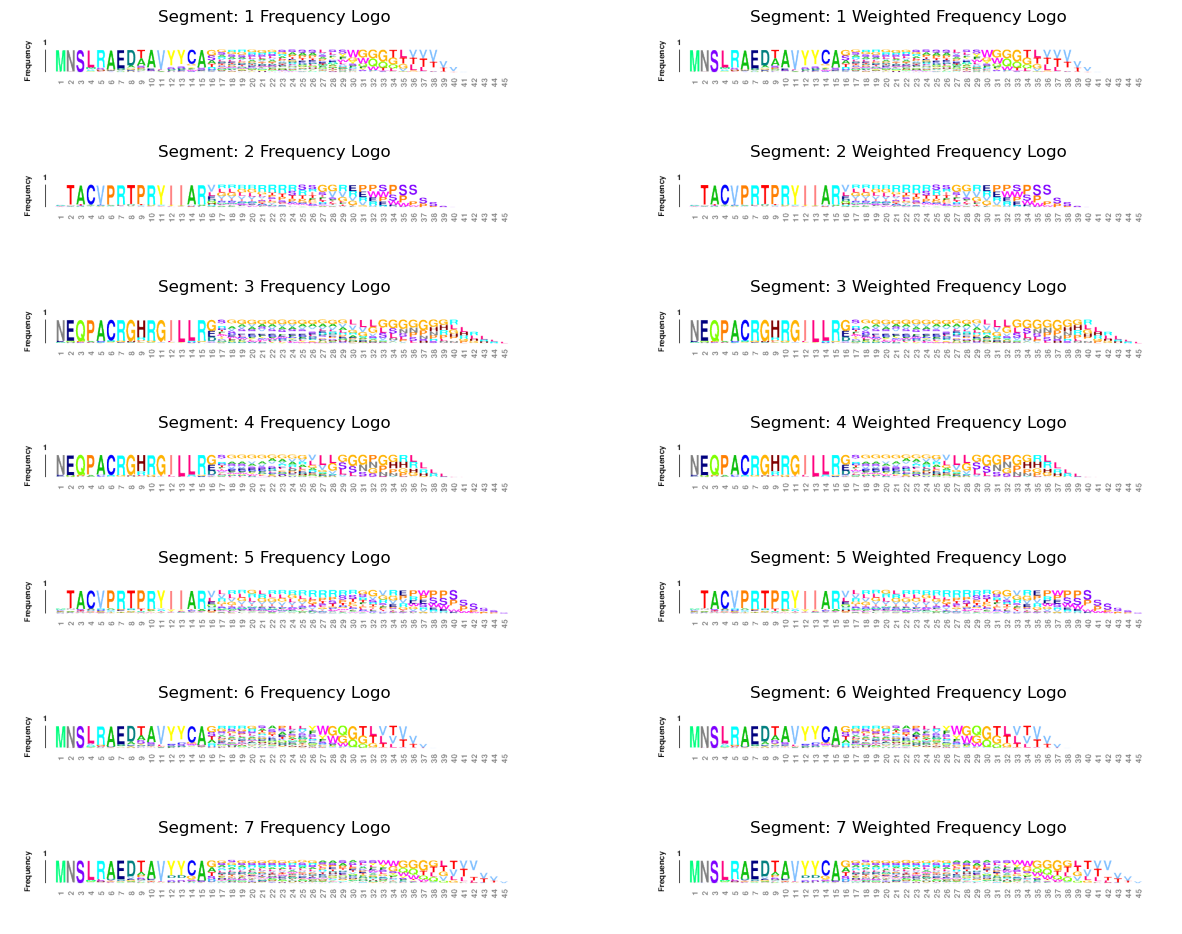

In [16]:
segments = ["1", "2", "3", "4", "5", "6", "7"]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"pca_pig_ge2_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"pca_pig_ge2_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

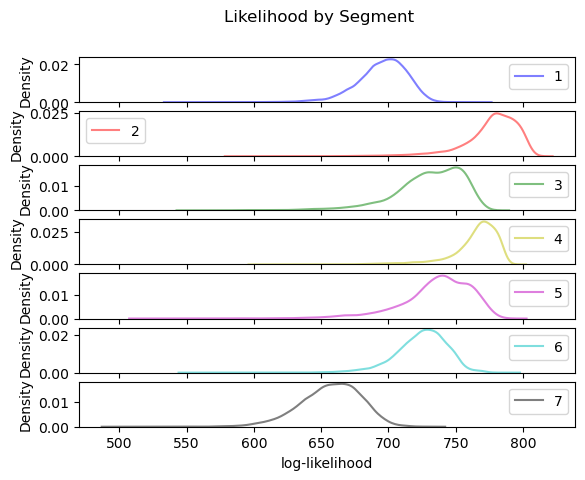

In [23]:
segments = ["1", "2", "3", "4", "5", "6", "7"]
# Plot Likelihood Curves of individual segments
# am.supported_colors = ["b", "r", "g", "y", "m", "c", "k", "DarkKhaki", "DarkOrchid"]
df_pca_kmeans["likelihood"] = np3_c2_likelihoods["likelihoods"]["np3_c2"]
segments_numbers = []
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    segments_numbers.append(len(likelihoods))
    likelihood_dict[seg] = likelihoods

total = sum(segments_numbers)
seg_percents = [str(x/ total * 100)[:5] for x in segments_numbers]

am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

In [24]:
seg_percents

['21.47', '9.951', '9.219', '14.41', '5.746', '24.74', '14.44']

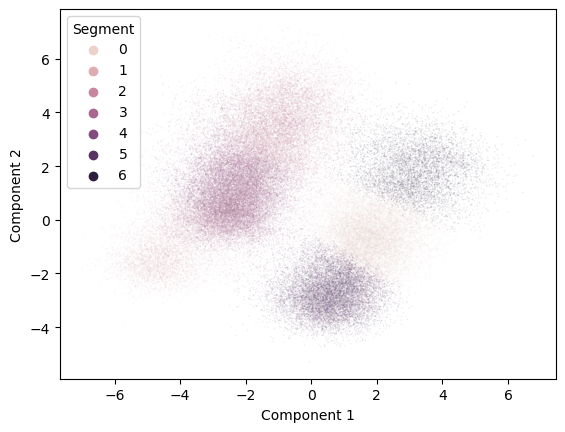

In [18]:
# NOW LETS CHECK LIKELIHOOD CURVES OF BASE LIBRARY separated by clusters
# prep input vector
input_b3 = prepare_input_vector(np3_crbm, data_c2[data_c2["round"] == "b3_c2"])
# Scale input vectors
input_processed = scaler.transform(input_b3)
# Calculate Components from previous fit on np3 data
b3_components = pca.transform(input_processed)
# Get per sequence cluster assignment by predicting the kmean cluster from the new PCA componenets
b3_cluster = kmeans_pca.predict(b3_components)

# Let's see how it clusters first
df_b3_segment = pd.DataFrame({"Segment": b3_cluster})
df_b3_components = pd.concat([df_b3_segment, pd.DataFrame(b3_components)], axis=1)
df_b3_components.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]

sns.scatterplot(data=df_b3_components, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

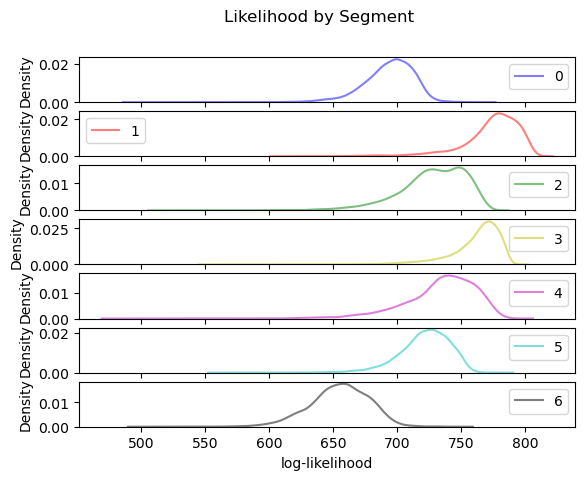

In [25]:
segments = [x for x in range(7)]
# Plot Likelihood Curves of individual segments
# am.supported_colors = ["b", "r", "g", "y", "m", "c", "k", "DarkKhaki", "DarkOrchid"]
df_b3_components["likelihood"] = np3_c2_likelihoods["likelihoods"]["b3_c2"]
likelihood_dict = {}
segments_numbers = []
for seg in segments:
    segment_subset = df_b3_components[df_b3_components["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    segments_numbers.append(len(likelihoods))
    likelihood_dict[seg] = likelihoods

total = sum(segments_numbers)
seg_percents = [str(x/ total * 100)[:5] for x in segments_numbers]

am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

In [26]:
seg_percents

['16.16', '7.561', '16.61', '29.42', '4.338', '17.40', '8.486']

In [46]:
high_likeli_np3 = am.data_subset(data_c2, np3_likeli, "np3_c2", -176, 0)
first_peak_np3 = am.data_subset(data_c2, np3_likeli, "np3_c2", -183, -176)
second_peak_np3 = am.data_subset(data_c2, np3_likeli, "np3_c2", -225, -183)
# third_peak_np3 = data_subset(data_c2, np3_likeli, "np3_c2", -90, -80)
# tail_np3 = data_subset(data_c2, np3_likeli, "np3_c2", -130, -90)
# np3_subsets = [high_likeli_np3, first_peak_np3, second_peak_np3, third_peak_np3, tail_np3]

hp = am.seq_logo(high_likeli_np3, "high_likeli_np3_c2", weight=False, outdir="./generated/")
fp = am.seq_logo(first_peak_np3, "first_peak_likeli_np3_c2", weight=False, outdir="./generated/")
sp = am.seq_logo(second_peak_np3, "second_peak_likeli_np3_c2", weight=False, outdir="./generated/")

peaks = [hp, fp, sp]

Text(0.5, 0.98, 'NP3 Likelihood and Sequence Logos')

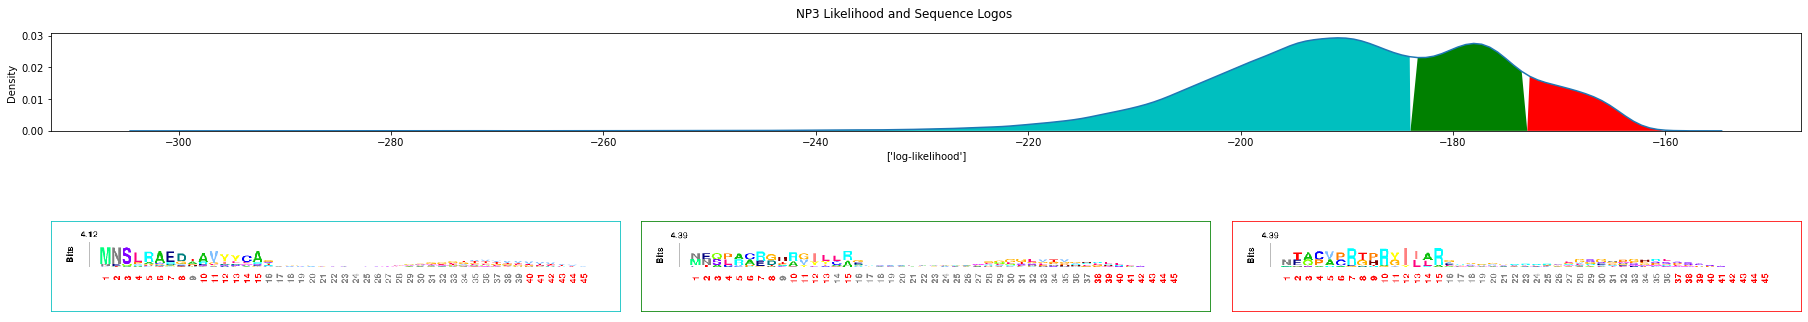

In [61]:
gs_kw = dict(width_ratios=[1, 1, 1], height_ratios=[0.5, 1])
fig, axd = plt.subplot_mosaic([['top', 'top', 'top'],
                               ['lower left', "middle", 'lower right']],
                              gridspec_kw=gs_kw, figsize=(25, 5),
                              constrained_layout=True)

sns.kdeplot(np3_likeli["np3_c2"], ax=axd["top"])
l = axd["top"].get_children()[0].get_path()
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in l.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

shaded_kde_curve(axd["top"], l, -173, -160, "r")
shaded_kde_curve(axd["top"], l, -184, -173, "g")
shaded_kde_curve(axd["top"], l, -240, -184, "c")
axd["top"].set_xlabel("log-likelihood")

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

color_subplot(axd["lower left"], "c")
color_subplot(axd["middle"], "g")
color_subplot(axd["lower right"], "r")

seqlogo_subplot(axd["lower left"], sp)
seqlogo_subplot(axd["middle"], fp)
seqlogo_subplot(axd["lower right"], hp)

fig.suptitle('NP3 Likelihood and Sequence Logos')

In [35]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("b3_c2")
b3_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
b3_likeli = am.generate_likelihoods(c2_rounds, b3_rbm, data_c2)

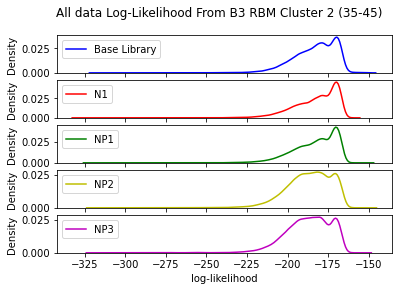

In [36]:
# assign likelihoods in new pd dataframe
b3_title = "All data Log-Likelihood From B3 RBM Cluster 2 (35-45)"
b3_xaxis = "log-likelihood"
b3_order = ["b3_c2", "n1_c2", "np1_c2", "np2_c2", "np3_c2"]
b3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
b3_colors = ["b", "r", "g", "y", "m"]

# Plot Likelihood Distributions
am.plot_likelihoods(b3_likeli, b3_title, b3_xaxis, b3_order, b3_labels, b3_colors)

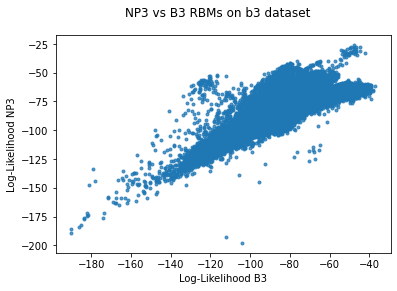

In [31]:
am.compare_likelihood_correlation(np3_c2_likelihoods["likelihoods"]["b3_c2"], b3_c2_likelihoods["likelihoods"]["b3_c2"], "NP3 vs B3 RBMs on b3 dataset", ["NP3", "B3"])

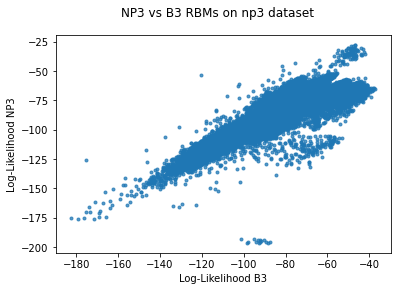

In [30]:
am.compare_likelihood_correlation(np3_likeli["np3_c2"], b3_likeli["np3_c2"], "NP3 vs B3 RBMs on np3 dataset", ["NP3", "B3"])

## Weighted RBMS

In [63]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("b3_c2_w", rbmdir=mdir)
b3_rbm_w = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
b3_likeli_w = am.generate_likelihoods(c2_rounds, b3_rbm_w, data_c2)

# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("np3_c2_w", rbmdir=mdir)
np3_rbm_w = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
np3_likeli_w = am.generate_likelihoods(c2_rounds, np3_rbm_w, data_c2)

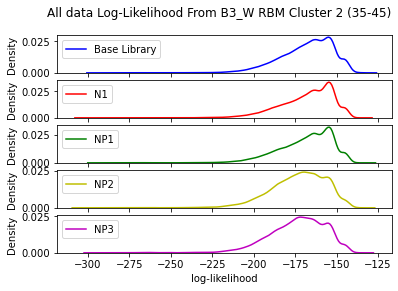

In [64]:
# assign likelihoods in new pd dataframe
b3_title = "All data Log-Likelihood From B3_W RBM Cluster 2 (35-45)"
b3_xaxis = "log-likelihood"
b3_order = ["b3_c2", "n1_c2", "np1_c2", "np2_c2", "np3_c2"]
b3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
b3_colors = ["b", "r", "g", "y", "m"]

# Plot Likelihood Distributions
am.plot_likelihoods(b3_likeli_w, b3_title, b3_xaxis, b3_order, b3_labels, b3_colors)

In [69]:
# Plot Likelihoods of Each batch of Data
np3_title = "All data Log-Likelihood From NP3 RBM Cluster 2 (35-45)"
np3_xaxis = "log-likelihood"
np3_order = ["b3_c2", "n1_c2", "np1_c2", "np2_c2", "np3_c2"]
np3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
np3_colors = ["b", "r", "g", "y", "m"]

# Should be Enough for most SELEX Experiments
supported_colors = ["b", "r", "g", "y", "m", "c", "w", "bl", "k", "c", "DarkKhaki", "DarkOrchid"]

am.plot_likelihoods(np3_likeli_w, np3_title, np3_xaxis, np3_order, np3_labels, np3_colors, clip=(-300, -100))

TypeError: plot_likelihoods() got an unexpected keyword argument 'clip'

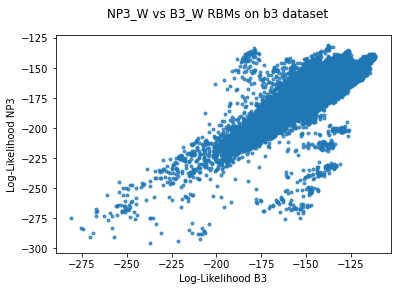

In [66]:
am.compare_likelihood_correlation(np3_likeli_w["b3_c2"], b3_likeli_w["b3_c2"], "NP3_W vs B3_W RBMs on b3 dataset", ["NP3", "B3"])

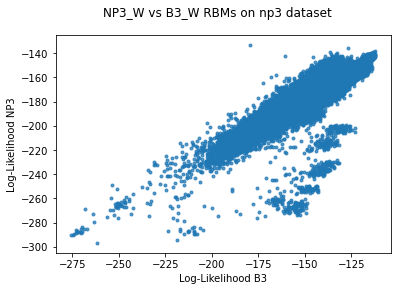

In [67]:
am.compare_likelihood_correlation(np3_likeli_w["np3_c2"], b3_likeli_w["np3_c2"], "NP3_W vs B3_W RBMs on np3 dataset", ["NP3", "B3"])